<a href="https://colab.research.google.com/github/VladislavBulatov/3-laborat/blob/main/%D0%9B%D0%B0%D0%B1%D0%B0_%E2%84%963.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Подключение нужных библиотек
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup

import statistics

import datetime

import matplotlib.pyplot as plt

from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook

In [ ]:
# Проанализируем содержимое кода страницы и извлечём из неё нужные данные. Так как в данный момент в открытом доступе только информация о частоте и температуре энергостанций,
# используем именно эти данные
def create_url_freq(date):
  url_begin = "https://so-ups.ru/functioning/ees/ees-indicators/ees-freq/?tx_mscdugraph_pi%5Bcontroller%5D=Graph&tx_mscdugraph_pi%5Baction%5D=fullview&tx_mscdugraph_pi%5BviewDate%5D="
  url_end = "&tx_mscdugraph_pi%5BviewKpo%5D=6100"
  return url_begin + date + url_end

def create_url_temp(date):
  url_begin = "https://so-ups.ru/functioning/ees/ees-indicators/ees-temperature/?tx_mscdugraph_pi%5Bcontroller%5D=Graph&tx_mscdugraph_pi%5Baction%5D=fullview&tx_mscdugraph_pi%5BviewDate%5D="
  url_end = "&tx_mscdugraph_pi%5BviewKpo%5D=6100"
  return url_begin + date + url_end

def parse_consumption(date):
  url = create_url_freq(date)
  soup = BeautifulSoup(requests.get(url).content, 'html.parser')
  full_txt = str(soup)
  text_list_datetime = full_txt[full_txt.find('data-datax=') + len('data-datax=') + 1 : full_txt.find('data-datay=') - 2].split(',')
  text_list_freq = full_txt[full_txt.find('data-datay=') + len('data-datay=') + 1 : full_txt.find('data-date=') - 2].split(',')

  new_date = datetime.datetime.strptime(date, "%Y-%m-%d").date()
  new_date += datetime.timedelta(days=1)
  url = create_url_temp(new_date.strftime("%Y-%m-%d"))
  soup = BeautifulSoup(requests.get(url).content, 'html.parser')
  full_txt = str(soup)
  text_list_date = full_txt[full_txt.find('data-datax=') + len('data-datax=') + 1 : full_txt.find('data-datay=') - 2].split(',')
  text_list_temp = full_txt[full_txt.find('data-datay=') + len('data-datay=') + 1 : full_txt.find('data-date=') - 2].split(',')

  df = pd.DataFrame([text_list_datetime, list(map(float, text_list_freq)), [text_list_temp[text_list_date.index(date + ' 0:00')]] * len(text_list_freq)])
  return df.T

In [ ]:
# Возьмём данные за последние 3 дня и склеим их в одну таблицу
df_power = parse_consumption('2023-06-04')
df_power = pd.concat([df_power, parse_consumption('2023-06-03')], axis=0, ignore_index = True)
df_power = pd.concat([df_power, parse_consumption('2023-06-02')], axis=0, ignore_index = True)
df_power

,0,1,2
0,2023-06-04 0:00,49.99,17.36
1,2023-06-04 1:00,49.98,17.36
2,2023-06-04 2:00,49.99,17.36
3,2023-06-04 3:00,49.99,17.36
4,2023-06-04 4:00,49.99,17.36
...,...,...,...
67,2023-06-02 19:00,49.99,17.90
68,2023-06-02 20:00,49.99,17.90
69,2023-06-02 21:00,50.01,17.90
70,2023-06-02 22:00,50.04,17.90


In [ ]:
# Переименуем столбцы
df_power_2 = df_power.copy()

df_power_2.columns = ['Дата и время', 'Частота, Гц', 'Температура, гр.C']

# Установим время в качестве метки строки
df_power_2 = df_power_2.set_index('Дата и время')

# Явно укажем, что данные - числа с плавающей запятой (float)
df_power_2['Частота, Гц'] = df_power_2['Частота, Гц'].astype('float')
df_power_2['Температура, гр.C'] = df_power_2['Температура, гр.C'].astype('float')

df_power_2

,"Частота, Гц","Температура, гр.C"
Дата и время,,
2023-06-04 0:00,49.99,17.36
2023-06-04 1:00,49.98,17.36
2023-06-04 2:00,49.99,17.36
2023-06-04 3:00,49.99,17.36
2023-06-04 4:00,49.99,17.36
...,...,...
2023-06-02 19:00,49.99,17.90
2023-06-02 20:00,49.99,17.90
2023-06-02 21:00,50.01,17.90


In [ ]:
# Отсортируем данные по возрастанию по столбцу "Дата и время"
df_power_2 = df_power_2.sort_values(['Дата и время'])
df_power_2

,"Частота, Гц","Температура, гр.C"
Дата и время,,
2023-06-02 0:00,49.99,17.90
2023-06-02 10:00,50.00,17.90
2023-06-02 11:00,50.00,17.90
2023-06-02 12:00,50.02,17.90
2023-06-02 13:00,50.01,17.90
...,...,...
2023-06-04 5:00,49.98,17.36
2023-06-04 6:00,50.00,17.36
2023-06-04 7:00,50.00,17.36


In [ ]:
# Добавление столбца с проверкой на уровень частоты
df_power_2['Уровень частоты'] = np.where(df_power_2['Частота, Гц'] < 50, 'Пониженный', np.where(df_power_2['Частота, Гц'] > 50, 'Повышенный', 'Нормированный'))
df_power_2

,"Частота, Гц","Температура, гр.C",Уровень частоты
Дата и время,,,
2023-06-02 0:00,49.99,17.90,Пониженный
2023-06-02 10:00,50.00,17.90,Нормированный
2023-06-02 11:00,50.00,17.90,Нормированный
2023-06-02 12:00,50.02,17.90,Повышенный
2023-06-02 13:00,50.01,17.90,Повышенный
...,...,...,...
2023-06-04 5:00,49.98,17.36,Пониженный
2023-06-04 6:00,50.00,17.36,Нормированный
2023-06-04 7:00,50.00,17.36,Нормированный


In [ ]:
# Выборка данных по условию
# Выборка данных с температурой выше 17.7 градусов по Цельсию.
print(df_power_2[df_power_2['Температура, гр.C'] > 17.7])
print()

# Выборка данных с частотой ниже 50 Гц.
print(df_power_2[df_power_2['Частота, Гц'] < 50.])
print() 

# Выборка данных с нормированным уровнем частоты
print(df_power_2[df_power_2['Уровень частоты'] == 'Нормированный'])
print() 

# Выборка данных с частотой выше 50.01 Гц. и температурой ниже 17.5 градусов по Цельсию.
print(df_power_2[(df_power_2['Частота, Гц'] > 50.01) & (df_power_2['Температура, гр.C'] < 17.5)])
print() 

                  Частота, Гц  Температура, гр.C Уровень частоты
Дата и время                                                    
2023-06-02 0:00         49.99               17.9      Пониженный
2023-06-02 10:00        50.00               17.9   Нормированный
2023-06-02 11:00        50.00               17.9   Нормированный
2023-06-02 12:00        50.02               17.9      Повышенный
2023-06-02 13:00        50.01               17.9      Повышенный
2023-06-02 14:00        50.00               17.9   Нормированный
2023-06-02 15:00        50.01               17.9      Повышенный
2023-06-02 16:00        49.98               17.9      Пониженный
2023-06-02 17:00        50.01               17.9      Повышенный
2023-06-02 18:00        50.01               17.9      Повышенный
2023-06-02 19:00        49.99               17.9      Пониженный
2023-06-02 1:00         50.00               17.9   Нормированный
2023-06-02 20:00        49.99               17.9      Пониженный
2023-06-02 21:00        5

In [ ]:
# Выборка различных фрагментов по номерам строк и столбцов
print('Данные из 10 строки и 1 столбца:')
print(df_power_2.iloc[10 , 1])
print()
print('Данные из всех строк кроме 48 последних и из столбцов с 0 по 2 невключительно:')
print(df_power_2.iloc[: -48, 0 : 2])
print()
print('Данные из нечетных строк и 2 столбца:')
print(df_power_2.iloc[ : : 2, 2])
print()

Данные из 10 строки и 1 столбца:
17.9

Данные из всех строк кроме 48 последних и из столбцов с 0 по 2 невключительно:
                  Частота, Гц  Температура, гр.C
Дата и время                                    
2023-06-02 0:00         49.99               17.9
2023-06-02 10:00        50.00               17.9
2023-06-02 11:00        50.00               17.9
2023-06-02 12:00        50.02               17.9
2023-06-02 13:00        50.01               17.9
2023-06-02 14:00        50.00               17.9
2023-06-02 15:00        50.01               17.9
2023-06-02 16:00        49.98               17.9
2023-06-02 17:00        50.01               17.9
2023-06-02 18:00        50.01               17.9
2023-06-02 19:00        49.99               17.9
2023-06-02 1:00         50.00               17.9
2023-06-02 20:00        49.99               17.9
2023-06-02 21:00        50.01               17.9
2023-06-02 22:00        50.04               17.9
2023-06-02 23:00        49.99               17.9


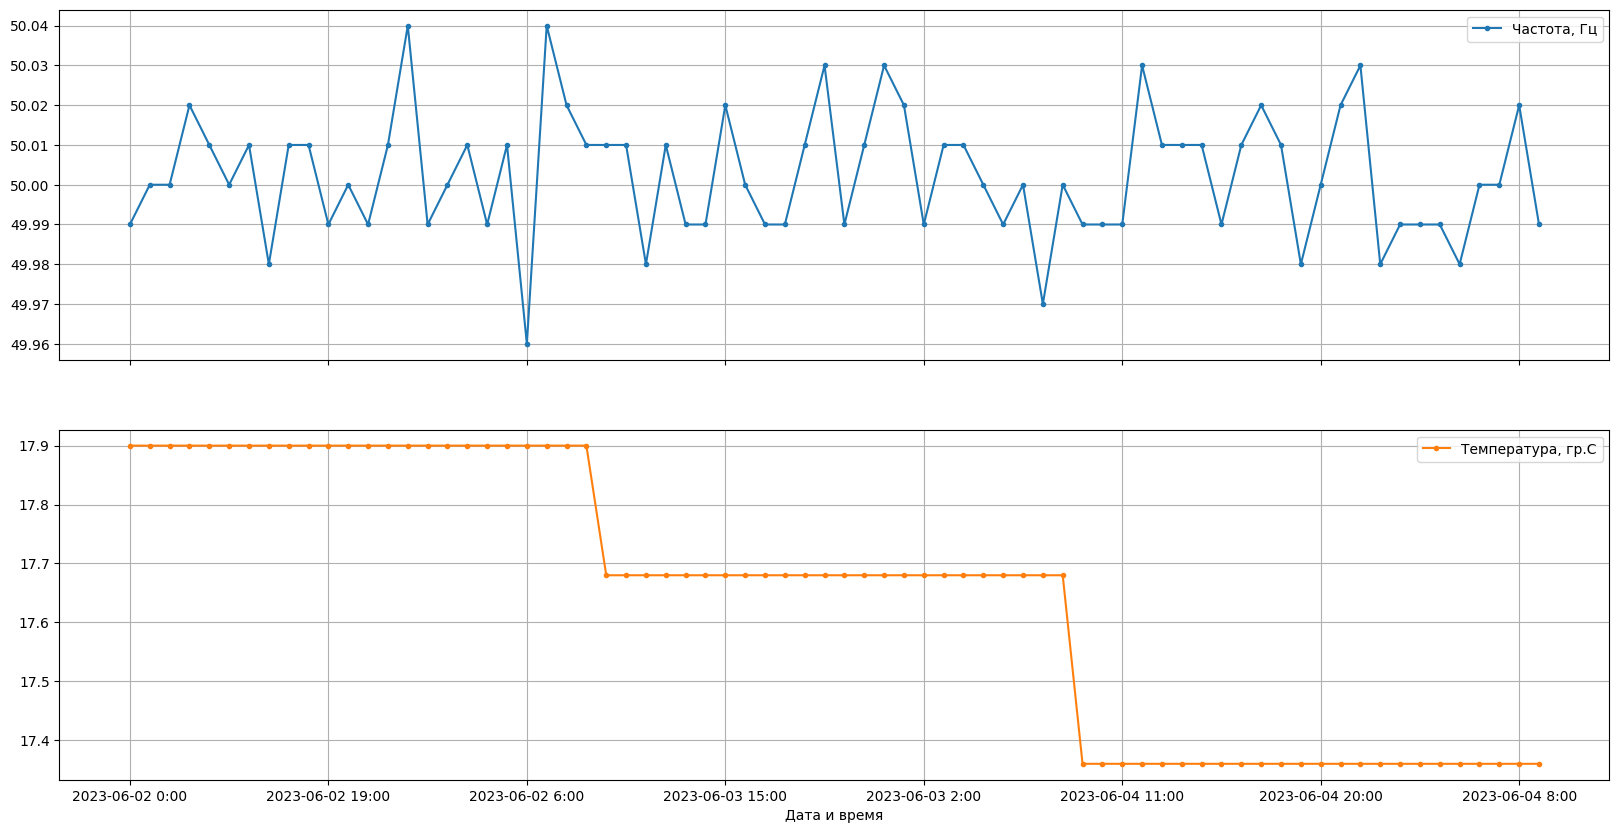

In [ ]:
# Построим графики
axes = df_power_2.plot(marker='.', figsize=(20, 10), subplots = True)

for _ in axes:
  _.grid(True)

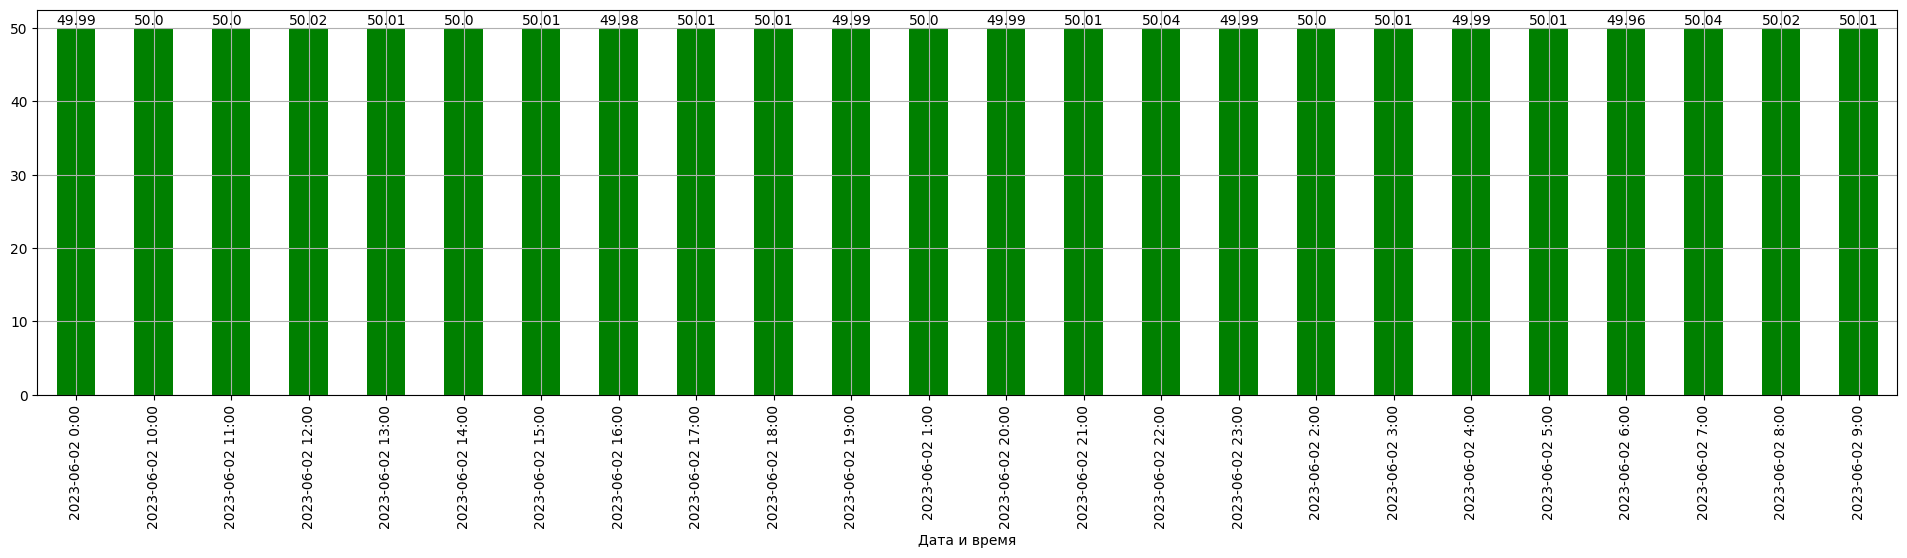

In [ ]:
# Гистограмма
axes = df_power_2.iloc[ : 24, 0].plot(kind = 'bar', figsize=(24, 5), color = 'green')

# Добавим точные значения каждому столбцу
for p in axes.patches:
  axes.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.01))

axes.grid(True)

In [ ]:
# Вывелем корреляцию
df_power_2.corr()

<ipython-input-12-a001b1bf6786>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_power_2.corr()


,"Частота, Гц","Температура, гр.C"
"Частота, Гц",1.000000,0.063396
"Температура, гр.C",0.063396,1.000000


<Axes: xlabel='Частота, Гц'>

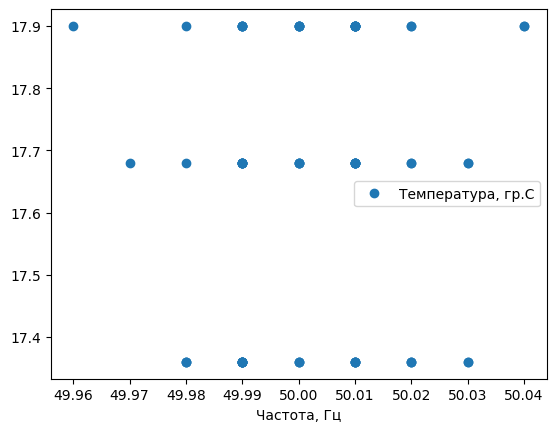

In [ ]:
# Выведем точечные графики, показывающие зависимости величин
df_power_2.plot(x = 'Частота, Гц', y = 'Температура, гр.C', style='o')
# Само собой данные несколько странные, так как нет смысла выводить графики зависимости частоты от температуры

In [ ]:
# Считаем данные из Excel-файла, полученного с сайта https://minenergo.gov.ru/activity/statistic
# Данные взяты немного старые, так как по ссылке в данный момент ведутся технические работы и получить свежий список не удаётся
df_init = pd.read_excel('https://drive.google.com/uc?export=download&id=1IFULWv72kGpZRDRpqRskm5NIM6AOCFPR', header = None)
df_init

,0,1
0,01.01.2013,103256.7
1,01.02.2013,91532.6
2,01.03.2013,97809.1
3,01.04.2013,85131.0
4,01.05.2013,79080.8
...,...,...
79,01.08.2019,83100.0
80,01.09.2019,84000.0
81,01.10.2019,93200.0
82,01.11.2019,98900.0


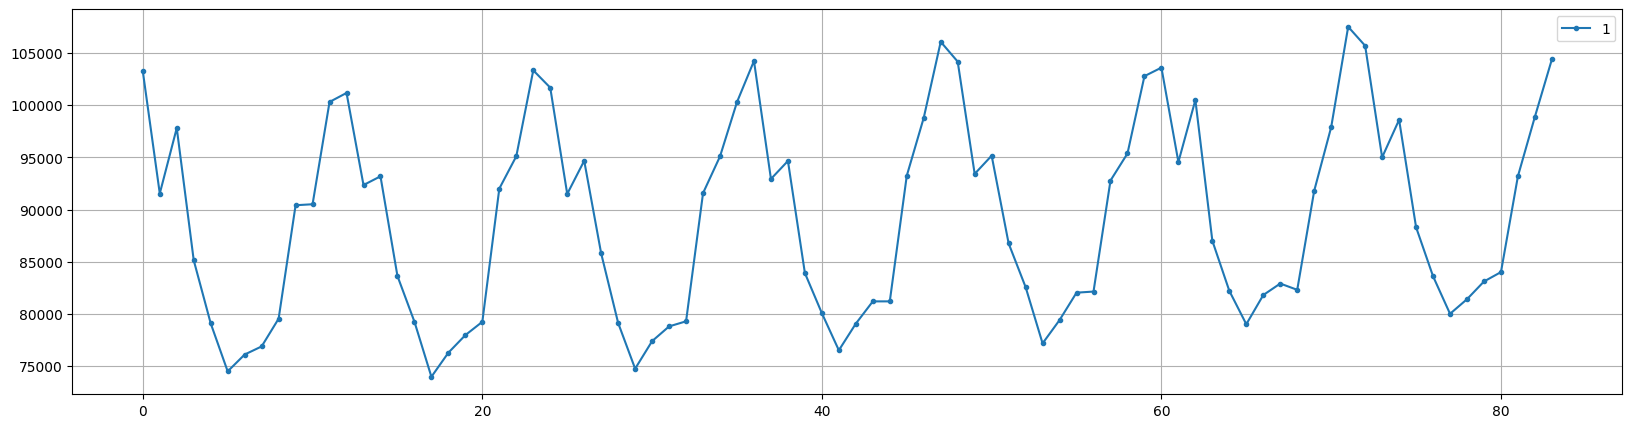

In [ ]:
# Выведем график по данным
axes = df_init.plot(marker='.', figsize=(20, 5), subplots = False)
axes.grid(True)

In [ ]:
# Разделим в строке дни, месяца и года
df_date = df_init[0].str.split('.', expand = True) 

# Создадим новую таблицу
df_gen = pd.DataFrame()

# Добавим в новую таблицу данные
df_gen['Generation, mln MWt*h'] = df_init[1] / 1000 # перевод кВтч в МВтч
df_gen['Month_ID'] = df_date[1].astype(int) # указание, что этот столбец хранит уже не строки, а целые числа (int - integer)
df_gen['Year'] = df_date[2].astype(int) 

df_gen

,"Generation, mln MWt*h",Month_ID,Year
0,103.2567,1,2013
1,91.5326,2,2013
2,97.8091,3,2013
3,85.1310,4,2013
4,79.0808,5,2013
...,...,...,...
79,83.1000,8,2019
80,84.0000,9,2019
81,93.2000,10,2019
82,98.9000,11,2019


Year
2013    1045.0155
2014    1047.4473
2015    1049.9049
2016    1071.8417
2017    1073.7239
2018    1091.0791
2019    1096.2000
Name: Generation, mln MWt*h, dtype: float64





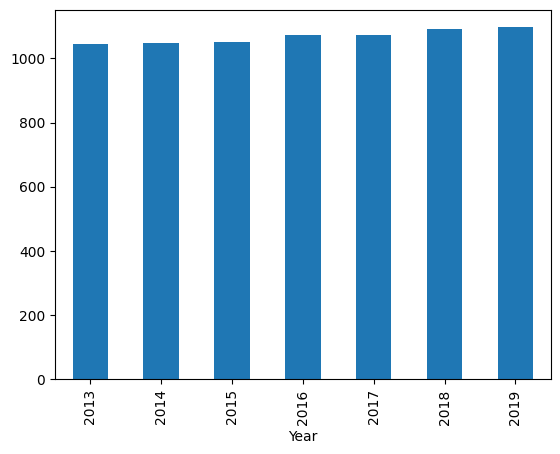

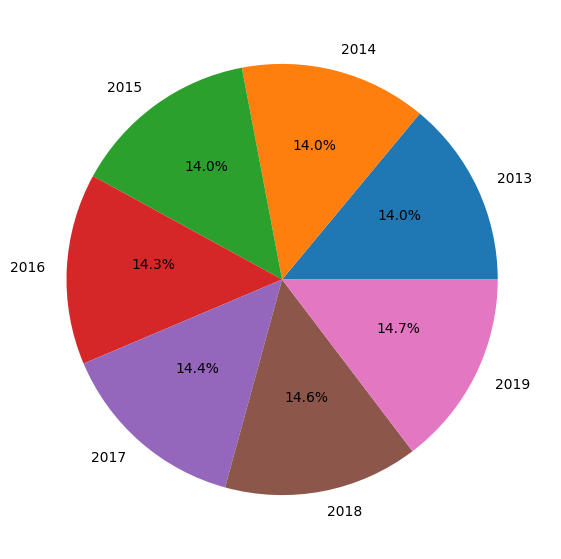

In [ ]:
# Выведем статистику суммарной генерации по годам, построим гистограмму и круговую диаграмму
year_stat = df_gen.groupby(['Year'])['Generation, mln MWt*h'].sum()

print(year_stat)
print()

year_stat.plot(kind = 'bar')
print()

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n".format(pct, absolute)

fig, ax = plt.subplots(figsize =(10, 7))
wedges = ax.pie(year_stat, labels = year_stat.index, autopct = lambda pct: func(pct, year_stat))
print()

Month_ID
1     723.8397
2     651.2704
3     674.5821
4     600.4886
5     565.8630
6     535.8456
7     551.4041
8     562.8380
9     567.6702
10    644.9951
11    671.6693
12    724.7463
Name: Generation, mln MWt*h, dtype: float64





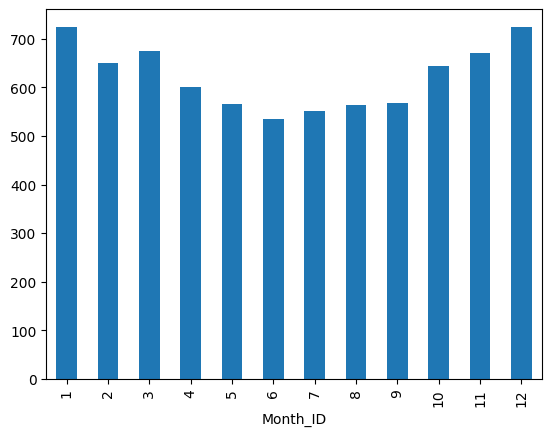

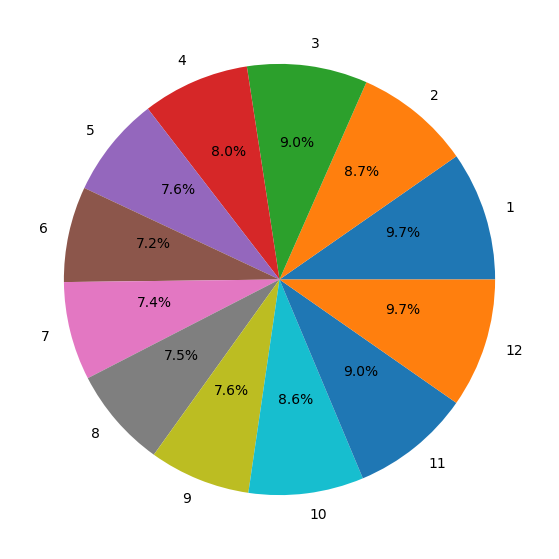

In [ ]:
# Выведем статистику суммарной генерации по месяцам, построим гистограмму и круговую диаграмму
month_stat = df_gen.groupby(['Month_ID'])['Generation, mln MWt*h'].sum()

print(month_stat)
print()

month_stat.plot(kind = 'bar')
print()

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n".format(pct, absolute)

fig, ax = plt.subplots(figsize =(10, 7))
wedges = ax.pie(month_stat, labels = month_stat.index, autopct = lambda pct: func(pct, month_stat))
print()

Month_ID
6     535.8456
7     551.4041
8     562.8380
5     565.8630
9     567.6702
4     600.4886
10    644.9951
2     651.2704
11    671.6693
3     674.5821
1     723.8397
12    724.7463
Name: Generation, mln MWt*h, dtype: float64





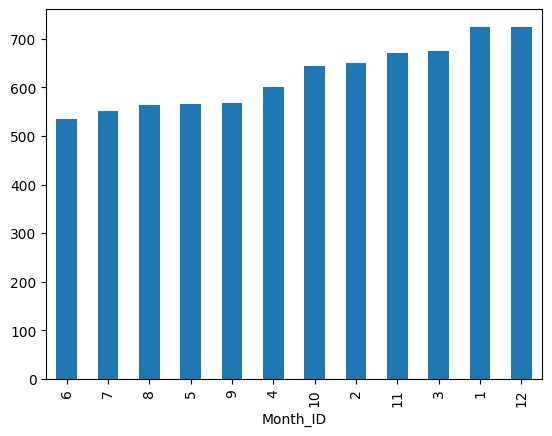

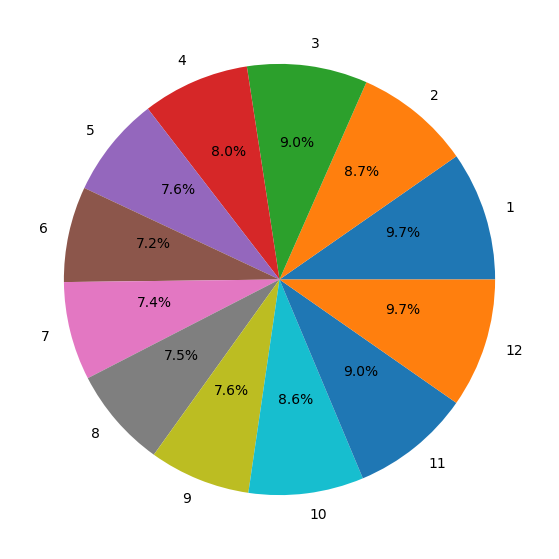

In [ ]:
# Отсортируем данные по возрастанию, построим гистограмму и круговую диаграмму
print(month_stat.sort_values())
print()

month_stat.sort_values().plot(kind = 'bar')
print()

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n".format(pct, absolute)

fig, ax = plt.subplots(figsize =(10, 7))
wedges = ax.pie(month_stat, labels = month_stat.index, autopct = lambda pct: func(pct, month_stat))
print()

In [ ]:
# Построим графики помесячной выработки за каждый год 
output_notebook()

p = figure(plot_width = 800, plot_height = 400)

# Список цветов по количеству лет
colors = ['magenta', 'red', 'yellow', 'green', 'cyan', 'blue', 'black']

# Для каждого года свой график
for year in range(2013, 2020):
  # Выбор из таблицы данных по выработке за нужный год
  values = df_gen[df_gen['Year'] == year]['Generation, mln MWt*h'].values 
  
  # Построение линий
  p.line(np.arange(1, 13), values, color = colors[year - 2013], legend_label = str(year), line_width = 3)

  # Построение маркеров
  p.circle(np.arange(1, 13), values, color = colors[year - 2013], alpha=0.5, size = 8)

show(p)